# Compute  PCA with Method 2 ICA

- use ICA scikit learn from scikit learn

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2022/12/28

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice

from astroML.utils.decorators import pickle_results


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
from sklearn.decomposition import NMF, FastICA, PCA

In [4]:
from astropy.io import fits

In [5]:
filename = 'pca_SL_data.fits'
hdu = fits.open(filename)
data_in=hdu[0].data

In [6]:
data_in

array([[0.00000000e+00, 9.10000000e+01, 9.40000000e+01, ...,
        9.95000000e+03, 9.97000000e+03, 9.99000000e+03],
       [0.00000000e+00, 4.97839069e-07, 5.52382959e-07, ...,
        7.06085364e-05, 7.06330908e-05, 7.05906948e-05],
       [0.00000000e+00, 1.19574179e-06, 1.27758431e-06, ...,
        4.46025945e-05, 4.46908296e-05, 4.46647757e-05],
       ...,
       [7.36000000e+02, 2.14675694e-06, 2.50389986e-06, ...,
        2.12861759e-05, 2.12363909e-05, 2.11664152e-05],
       [7.37000000e+02, 8.31448778e-07, 9.57832321e-07, ...,
        7.00733914e-05, 6.99426115e-05, 7.00519814e-05],
       [7.38000000e+02, 7.21010321e-08, 8.01113405e-08, ...,
        1.50517900e-04, 1.50795383e-04, 1.50744720e-04]])

In [7]:
NSED = data_in.shape[0]-3
NWL = data_in.shape[1]-1

In [8]:
wavelengths = data_in[0,1:] 
flambdas_average = data_in[1,1:] 
flambdas_std = data_in[2,1:] 
spec = data_in[3:,1:] 
all_numbers = data_in[3:,0] 

In [9]:
#flux = dfluxnorm*flambdas_std +  flambdas_average

/var/folders/rk/cnrspsj13_3cgmh8p4m_mxww0000gp/T/ipykernel_50367/1659706449.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])


Text(0.5, 1.0, 'Flux average')

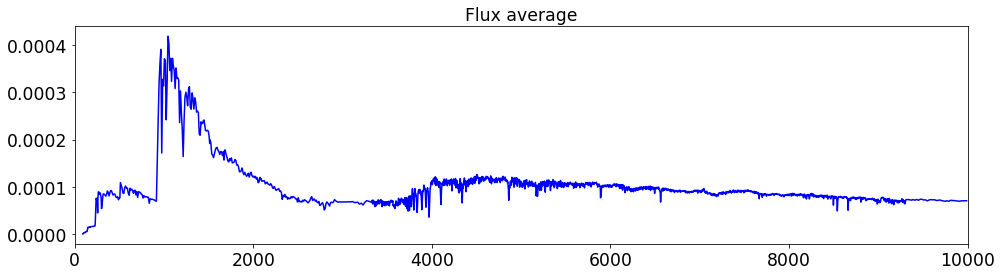

In [10]:
plt.figure(figsize=(16,4))
plt.plot(wavelengths,flambdas_average,'b-')
plt.xlim(0.,10000.)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.title("Flux average")

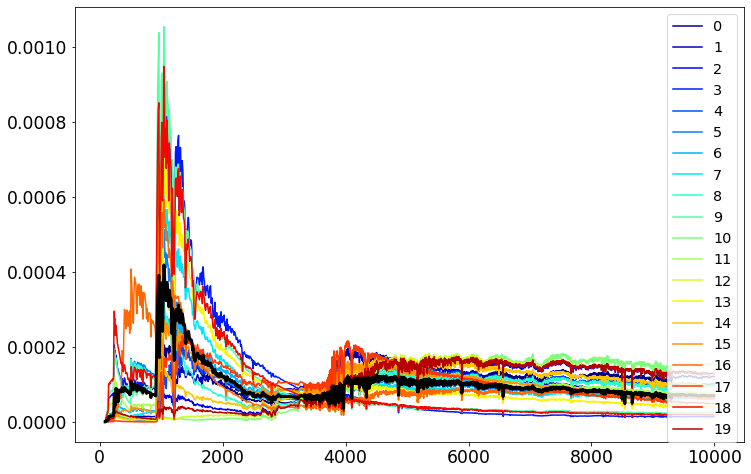

In [11]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    plt.plot(wavelengths,spec[idx,:],color=all_colors[idx],label=str(idx))

plt.legend()
spec_mean = spec.mean(0)
plt.plot(wavelengths,spec_mean,"k-",lw=3)
#plt.ylim(0,50.)

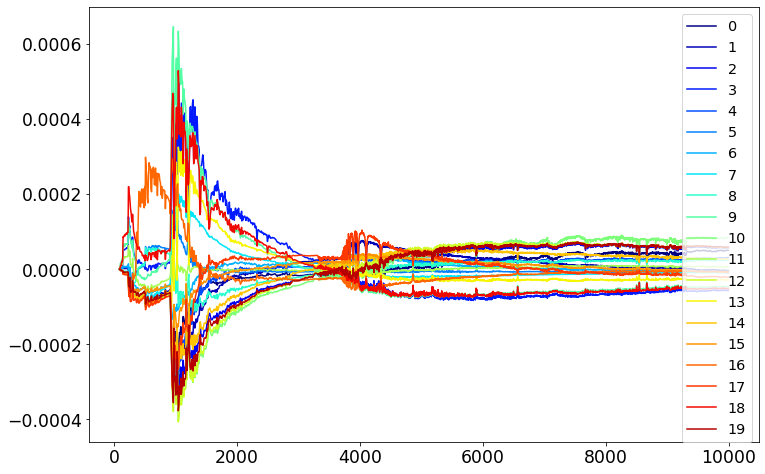

In [44]:
# wavelength bin colors
NTOPLOT=20
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTOPLOT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTOPLOT), alpha=1)


fig = plt.figure(figsize=(12, 8))

for idx in np.arange(20):
    dflux=spec[idx,:]-spec.mean(0)
    plt.plot(wavelengths,dflux,color=all_colors[idx],label=str(idx))

plt.legend()

In [12]:
#https://www.astroml.org/astroML-notebooks/chapter7/astroml_chapter7_Dimensionality_Reduction.html
#https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca

In [45]:
Ncomp=51

dflux = spec-spec_mean

#ica = FastICA(n_components=Ncomp, random_state=0,whiten="arbitrary-variance")
ica = FastICA(n_components=Ncomp, random_state=0,whiten='unit-variance')
#ica.fit(spec.T)
ica.fit(dflux.T)
ica_comp = np.vstack([flambdas_average,ica.transform(dflux.T).T])
X_transformed = ica.fit_transform(dflux.T)

In [46]:
dflux.shape

(550, 6361)

In [47]:
X_transformed.shape

(6361, 51)

In [48]:
X_transformed[:,0]

array([ 0.00087297,  0.000916  ,  0.00095487, ..., -0.00038648,
       -0.01294518,  0.00114852])

In [49]:
ica.transform(spec.T).T.shape

(51, 6361)

In [50]:
ica.transform(spec.T).T[0,:]

array([   -7295.50356668,    -8094.8084057 ,    -8483.89593452, ...,
       -1034721.70769131, -1035081.5489372 , -1034460.24879146])

In [51]:
ica_comp.shape

(52, 6361)

In [52]:
ica_comp[1,:]

array([ 0.00087285,  0.000916  ,  0.00095439, ..., -0.00038618,
       -0.01294535,  0.00114858])

In [53]:
ica.mixing_.shape

(550, 51)

In [54]:
import copy
X = copy.deepcopy(spec)
n_samples = X.shape[0]
X -= np.mean(X, axis=0)
cov_matrix = np.dot(X.T, X) / n_samples
evecs = []
evals = []
for idx in range(Ncomp):
    eigenvector = ica_comp[idx+1,:]
    eigenvalue = np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
    evecs.append(eigenvector)
    evals.append(eigenvalue)
    print(f"eigen value {idx} : ",eigenvalue)

eigen value 0 :  2.0134026967274555e-10
eigen value 1 :  1.38848757219947e-07
eigen value 2 :  1.110763789790205e-06
eigen value 3 :  5.686585581728666e-07
eigen value 4 :  1.4731281950875337e-07
eigen value 5 :  5.660899710932572e-08
eigen value 6 :  2.512603231937213e-08
eigen value 7 :  2.955518284943551e-10
eigen value 8 :  4.808550161187661e-07
eigen value 9 :  1.4126559218791052e-10
eigen value 10 :  7.264318627309185e-08
eigen value 11 :  2.7747495795028172e-09
eigen value 12 :  8.062871771234164e-11
eigen value 13 :  3.782359602935784e-08
eigen value 14 :  1.0176180699795857e-07
eigen value 15 :  6.488367765200386e-09
eigen value 16 :  3.2573176853707924e-08
eigen value 17 :  1.0659649441959495e-09
eigen value 18 :  7.410101745667218e-08
eigen value 19 :  1.2793144329417857e-10
eigen value 20 :  1.2305210910043583e-06
eigen value 21 :  7.339686318684359e-07
eigen value 22 :  2.5487708312696188e-08
eigen value 23 :  4.4042440500550496e-11
eigen value 24 :  3.960823844654662e-08


In [55]:
evecs = np.vstack(evecs)
evals=np.array(evals)

In [56]:
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]

coeff =  [-2.62076993e-05 -6.73346972e-04  8.15926074e-04  5.38146813e-04
 -6.62804846e-04 -7.97908064e-05 -2.67804091e-04 -2.93921762e-05
  3.52385497e-04 -2.94007549e-06 -1.59307866e-04  4.13817865e-05
 -5.99756119e-06 -9.88864648e-05 -1.20219097e-04  1.32939880e-04
  7.11024174e-05 -5.67756523e-05  2.14909565e-04 -1.89020812e-05
 -6.94098647e-04  4.96968113e-04 -7.58350727e-05 -1.07318829e-05
  3.53826411e-04 -8.46766046e-04  3.86693154e-05 -4.52474172e-04
  2.93961722e-04 -2.67694081e-05  1.66866392e-04  1.99088680e-04
  1.88353902e-04  9.30896703e-05  1.28813443e-04  3.91154509e-04
  3.58747000e-04  1.00544402e-04 -3.27373596e-04 -1.31215330e-05
 -2.23104123e-04  4.07873372e-05 -3.44048127e-04  1.46392461e-04
  5.83283205e-04 -3.41219748e-04 -9.24955843e-05  1.59962764e-04
  1.35660624e-04  6.17689251e-04 -8.12527577e-05]
ica.mixing =  [-2.60192093e-05 -6.73258209e-04  8.09572423e-04  5.33610006e-04
 -6.62009287e-04 -7.85809941e-05 -2.67834026e-04 -2.90800611e-05
  3.49852733e-04 

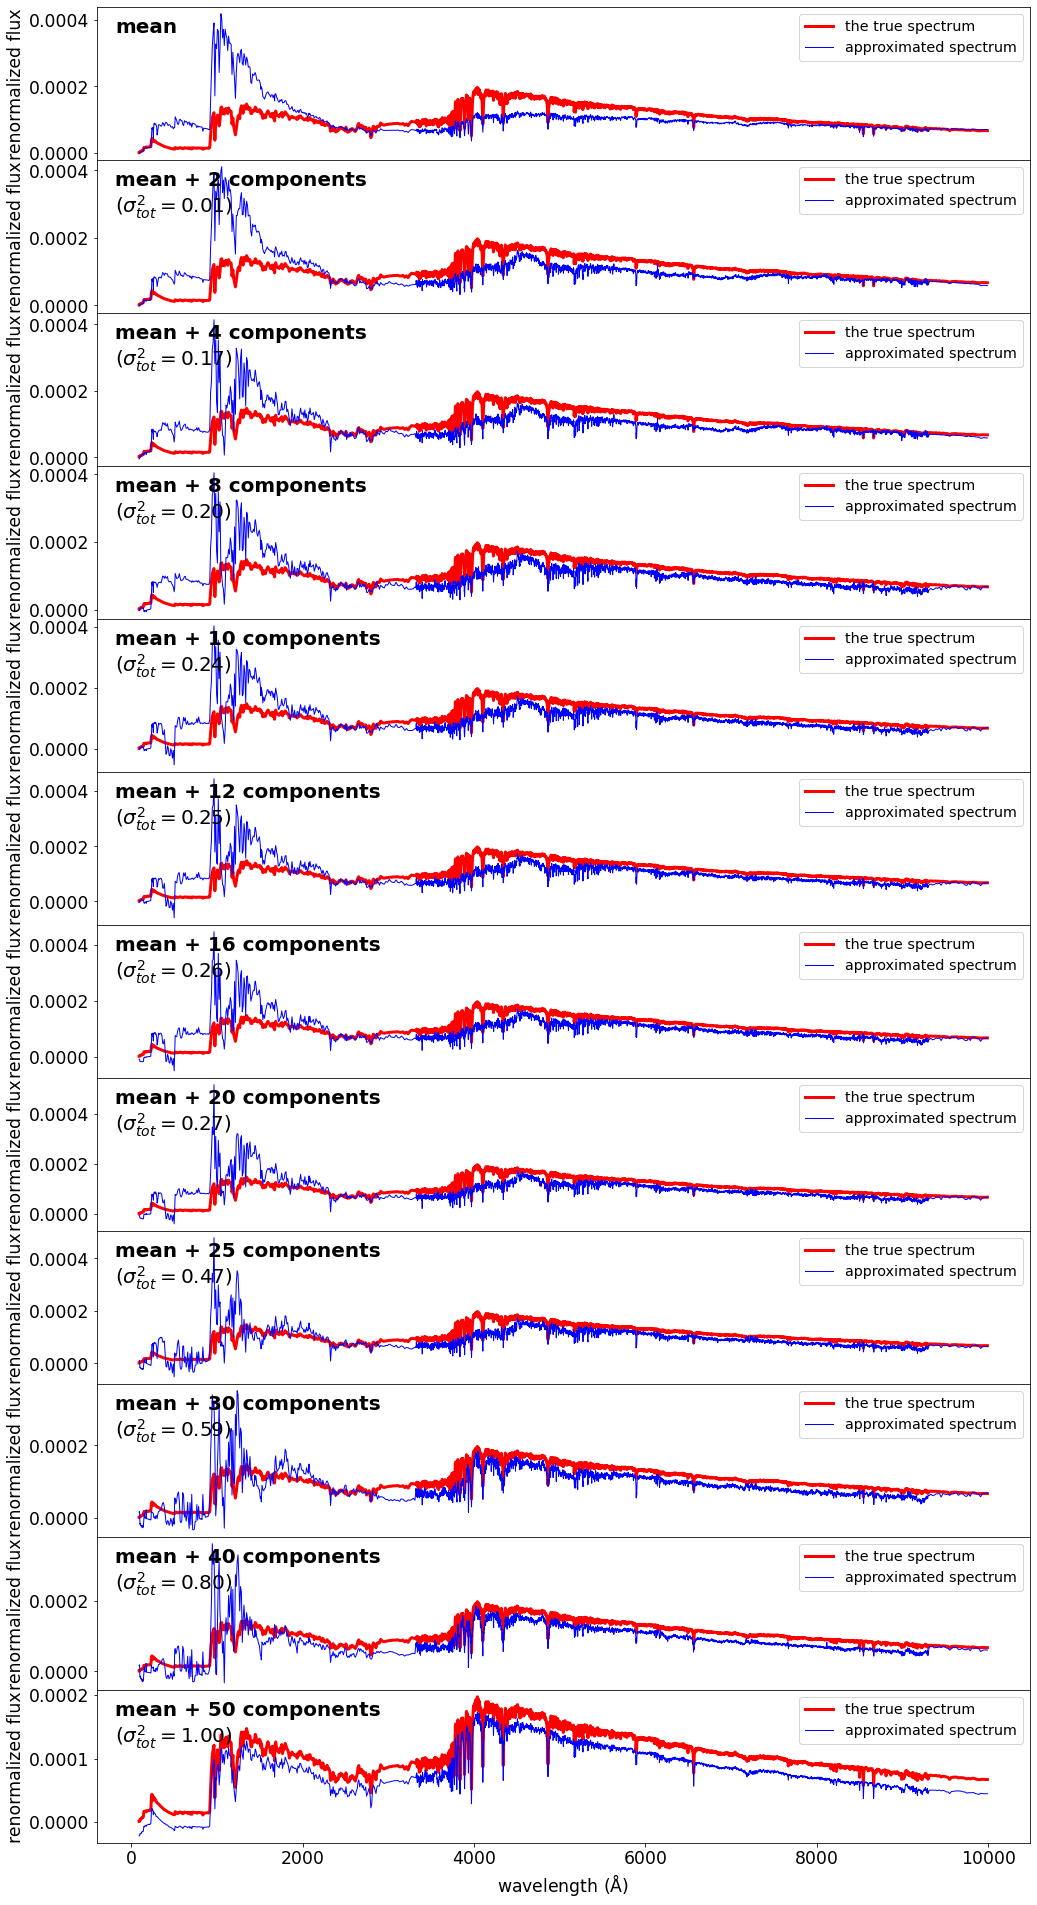

In [58]:
#------------------------------------------------------------
# Find the coefficients of a particular spectrum
idx=1
the_spec = spec[idx,:]
the_dflux = dflux[idx,:]
#coeff = np.dot(evecs, the_spec - spec_mean)
coeff = np.dot(evecs, the_dflux)
print("coeff = ",coeff)
print("ica.mixing = ",ica.mixing_[idx,:])
other_coeff=ica.mixing_[idx,:]

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(16, 30))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 2 , 4, 8, 10 , 12, 16, 20,25,30, 40, 50]):
    ax = fig.add_subplot(12,1,1 + i)
    ax.plot(wavelengths, the_spec, '-', color='red',lw=3,label="the true spectrum")
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-b',lw=1,label="approximated spectrum")
    #ax.plot(wavelengths, spec_mean + np.dot(other_coeff[:n], evecs[:n]), '-b',lw=1,label="approximated spectrum")

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    #ax.set_ylim(-2, 21)
    ax.set_ylabel('renormalized flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes,fontsize=20,fontweight="bold")
    ax.legend()

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

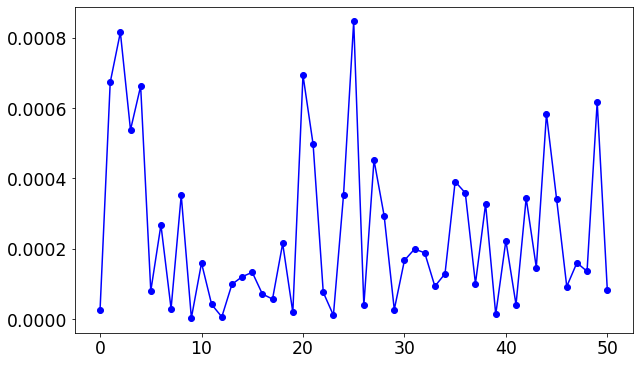

In [59]:
#plt.step(np.arange(len(coeff)),coeff)
plt.plot(range(len(coeff)),np.abs(coeff),'ob-')

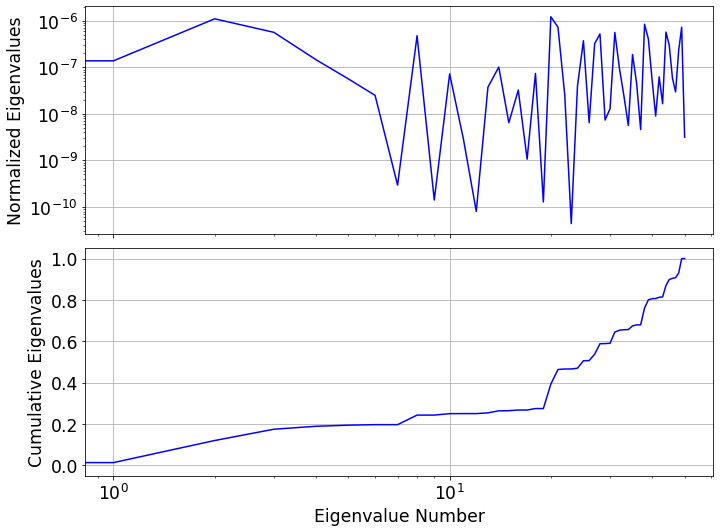

In [60]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='b')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
#ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='b')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
#ax.set_ylim(0.65, 1.00)
plt.tight_layout()
plt.show()
